## CSA-3D active site superposition tests
Exported entries from the mcsa3d package (with `pickle`) can be loaded and used as normal without having to rebuild
them each time. This significantly saves times and holds the advantage that the methods code in the packaged can be
modified and take effect in runtime, without having to rebuild the objects.

Here we will make some example active site superpositions to test the fitting and PDB writting methods.


### Imports

In [1]:
import os
import pickle
from time import time

### Load pickled entry

An medium-sized entry like M-CSA 4 (~400 PDB homologues) took around 2 mins to build, including all annotations and redundancy reduction. Parallelizing all 1000 entries is straightforward and should not take too long to build the whole database.

In [2]:
i = time()
with open('./csa3d_0005.ent', 'rb') as f: # Read as binary
    entry = pickle.load(f)
f = time()
print('Loading time: {:3f} seconds'.format(f-i))

Loading time: 4.457903 seconds


### Test printing some PDB sites in pseudo-sequence

We simply use `str(pdbsite)` or directly `print(pdbsite)` to get pseudo-sequence representation. Non-aligned residues are marked as gaps (`_`)

In [3]:
for i, pdbsite in enumerate(entry.pdbsites):
    print(pdbsite.id, pdbsite)
    if i==10:
        break

1whs_A-A-B-B-A YGDHS
3sc2_A-A-B-B-A YGDHS
1gxs_C-C-D-D-C EGDHG
4cib_A-A-A-A-A YGDHS
1bcr_A-A-B-B-A YGDHS
4mws_A-A-A-A-A YGDHS
4mwt_A-A-A-A-A YGDHS
1ivy_B-B-B-B-B YGDHS
1cpy_A-A---A YG__S
1bcs_A-A-B-B-A YGDHS
4az0_A-A-B-B-A YGDHS


### Fit sites to reference
`pdbsite.fit(other_pdbsite, cycles=10, cutoff=6, mutate=True, reorder=True, tranform=False)` function
outputs the rotation matrix and translation vector of the fitting, the RMSD of the fitted atoms
(excluding outliers) as well as the RMSD over all atoms, including outliers. We can also select the number of outlier
rejection iterations and a distance cutoff, with default 10 cycles and 6Ang respectively. Atom reordering within a residue
is possible with `reorder`. This is particularly useful when fitting residues with symmetrical atoms like Asp or His.
When comparing sites that might have different residues, we can use `mutate` to introduce pseudo-mutations to facilitate
superposition. Non-aligned residues in sequence are automatically excluded from the fitting. If `transform` is True
then the coordinates of the site will be automatically transformed. Otherwise we can use the rotation/translation
matrices to do the transformation manually using the `site.structure.transform(rot, tran)` function.

In [4]:
conserved = dict() # To store RMSD values of conserved sites
non_conserved = dict() # To store RMSD values of non-conserved sites
for pdbsite in entry.pdbsites:
    rot, tran, rms, rms_all = pdbsite.reference_site.fit(pdbsite, cycles=5, cutoff=6, transform=True)
    if rms_all < 10:
        if pdbsite.is_conserved or pdbsite.is_conservative_mutation: # To fit only conserved active sites
                                                                     # or sites with conservative mutations
            conserved[pdbsite.id] = (rms, rms_all)
        else:
            non_conserved[pdbsite.id] = (rms, rms_all)

### Show some RMSD values

In [5]:
i=0
for k,v in non_conserved.items():
    print(k, v)
    if i==10:
        break
    i+=1

1gxs_C-C-D-D-C (1.933, 3.83)
1cpy_A-A---A (0.563, 0.563)
1ac5_A-A---A (0.534, 0.534)
1ysc_A-A---A (0.628, 0.628)
1wpx_A-A---A (0.693, 0.693)


### Compute RMSD variance for conserved and non-conserved

In [6]:
import numpy as np

cons_rms_all = np.array([v[1] for v in conserved.values()])
non_cons_rms_all = np.array([v[1] for v in non_conserved.values()])
print('Variance of RMSD over all atoms')
print('Conserved: {:5f}'.format(np.var(cons_rms_all)))
print('Non-conserved: {:5f}'.format(np.var(non_cons_rms_all)))

Variance of RMSD over all atoms
Conserved: 0.037303
Non-conserved: 1.667631


### Draw Sequence logos

We can dump pseudosequences in a list and use `logomaker` to produce WebLogo-like sequence logos. Pretty useful package.

Text(0.5, 1.0, 'Non-conserved PDB sites')

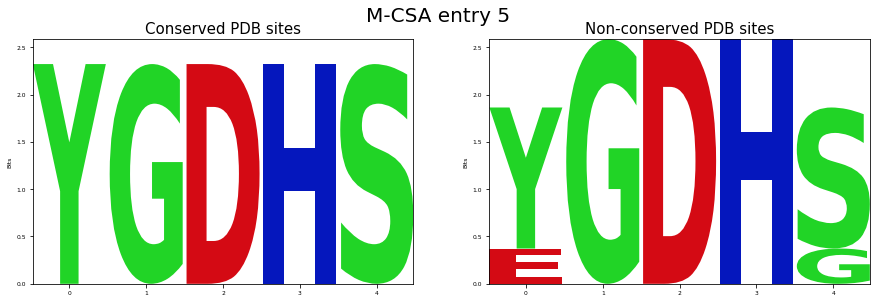

In [7]:
import logomaker as lm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
#%matplotlib inline

# Dump seqs in lists
conserved_seqs = []
non_conserved_seqs = []
for id in conserved:
    pdbsite = entry.get_pdbsite(id)
    conserved_seqs.append(str(pdbsite))
for id in non_conserved:
    pdbsite = entry.get_pdbsite(id)
    non_conserved_seqs.append(str(pdbsite))

# Make logo matrices
mat1 = lm.alignment_to_matrix(conserved_seqs, pseudocount=0, to_type='information', characters_to_ignore='_X')
mat2 = lm.alignment_to_matrix(non_conserved_seqs, pseudocount=0, to_type='information', characters_to_ignore='_X')

# Define y axis limits
ylim = max(mat1.max().max(), mat2.max().max())

# set default styling 
fontsize=6
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['text.usetex'] = False

# create figure and gridspec
fig = plt.figure(figsize=(15, 4.5))
fig.suptitle('M-CSA entry {}'.format(entry.mcsa_id), fontsize=20)
gs = gridspec.GridSpec(nrows=1, ncols=2)

# Conserved Logo
ax = fig.add_subplot(gs[0, 0])
logo = lm.Logo(mat1, ax=ax, color_scheme='weblogo_protein')
logo.ax.set_ylim([0, ylim])
logo.ax.set_ylabel('Bits')
logo.ax.set_title('Conserved PDB sites', fontsize=15)

# Non-conserved Logo
ax = fig.add_subplot(gs[0, 1])
logo = lm.Logo(mat2, ax=ax, color_scheme='weblogo_protein')
logo.ax.set_ylim([0, ylim])
logo.ax.set_ylabel('Bits')
logo.ax.set_title('Non-conserved PDB sites', fontsize=15)

### Write PDB files

`pdbsite.write_pdb(outfile=None, outdir=None, write_hets=True, func_atoms_only=True)` writes active sites in PDB format,
including REMARK entries with all annotations. If outfile is not specified, a unique filename is used, containing info like
M-CSA ID, PDB ID, chains, and conservation (c: conserved, m: mutated, cm: only conservative mutatations) We have options
to write nearby hetero components coordinates (`write_hets`) and write only functional atoms in the PDB (`func_atoms_only`).

We want to make a series of figures demonstrating the capabilities of the package, so we will use our own filenames.

In [8]:
try:
    os.makedirs('out/conserved/')
    os.makedirs('out/non-conserved/')
except FileExistsError:
    pass
for id in conserved:
    pdbsite = entry.get_pdbsite(id) # To get a site from the entry by unique ID
    pdbsite.write_pdb(outdir='out/conserved/', write_hets=False, func_atoms_only=True)
    pdbsite.write_pdb(outdir='out/conserved/', write_hets=True, func_atoms_only=False)

for id in non_conserved:
    pdbsite = entry.get_pdbsite(id) # To get a site from the entry by unique ID
    pdbsite.write_pdb(outdir='out/non-conserved/', write_hets=False, func_atoms_only=True)
    pdbsite.write_pdb(outdir='out/non-conserved/', write_hets=True, func_atoms_only=False)